In [2]:
# adding Folder_2 to the system path
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pygam
from pygam import LinearGAM
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import panel as pn
import geopandas as gpd
import contextily as cx

### Spatial GAM

In [3]:
# Read and setup metadata 
metadata = pd.read_csv("../../config/gaardian_metadata.tsv", sep="\t")
# Get average lat/long within a village so we can get one value per location
meta_locs = metadata.groupby('location').agg({'latitude':'mean', 'longitude':'mean'}).reset_index()
# Get species proportions per village
meta = pd.crosstab(metadata['species_gambiae_coluzzii'], metadata['location']).T.reset_index()
meta = meta.merge(meta_locs)
# Get Eco data
eco = metadata[['location', 'mining']].drop_duplicates().reset_index(drop=True)
# Merge back with metadata
meta = meta.merge(eco)

In [ ]:
# Read variant data, pre calculated
df = pd.read_csv(f"../../results/variantsOfInterest/VOI.ag3_gaardian.frequencies.tsv", sep="\t", index_col=0)
# Make long format 
af_long = df.iloc[:, 4:].melt(id_vars=['name'], var_name='cohort', value_name='AlleleFrequency')
af_long['aa_change'] = af_long['name'].str.split("|").str.get(-1).str.replace(" ", "")
af_long['location'] = af_long['cohort'].str.split("|").str.get(-1).str.replace(" ", "")
af_long = af_long.merge(metadata[['location', 'latitude', 'longitude']].drop_duplicates('location'))

In [4]:
lonmin = metadata['longitude'].min()
lonmax = metadata['longitude'].max()
latmin = metadata['latitude'].min()
latmax = metadata['latitude'].max()

def modelAF(snp_var, model_var, nsplines_var):
    if model_var == 'GAM':
        return(gamAF(snp_var, nsplines_var))
    elif model_var == 'Interpolate':
        return(interpAF(snp_var))

def gamAF(variantOfInterest, n_splines):
    """
    Given Variant of interest and number of splines, produce spatial GAM to model allele frequency
    """
    
    af_voi = af_long.query("aa_change == @variantOfInterest")
    X = af_voi[['latitude', 'longitude']]
    y = af_voi[['AlleleFrequency']]

    # Fit simple model, lat/long v allele frequency
    gam = LinearGAM(n_splines=n_splines).fit(X,y)

    stepsize = 0.005
    xs = np.array([])
    ys = np.array([])
    for x in np.arange(lonmin, lonmax, stepsize):
        for y in np.arange(latmin, latmax, stepsize):
            xs = np.append(xs, x)
            ys = np.append(ys, y)

    grid = pd.DataFrame({'y':ys, 'x':xs})
    predictions = gam.predict(grid)
    grid['predicted_af'] = np.clip(predictions,0,1)
    plot = plt.figure(figsize=(7, 5))
    ax = plot.add_subplot(111)
    cs = ax.scatter(grid['x'], grid['y'], c=grid['predicted_af'], cmap='rocket')
    plt.colorbar(cs)
    #cs.set_clim(vmin=0, vmax=1)
    plt.title(variantOfInterest)
    for x_, y_, name in zip(af_voi['longitude'], af_voi['latitude'], af_voi['AlleleFrequency']):
        ax.text(x_+0.01, y_, name, fontsize=13, color="black", bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))
    return(plot)

def interpAF(variantOfInterest):
    """
    Given a variant of interest, produce interpolation map
    """
    af_voi = af_long.query("aa_change == @variantOfInterest")

    coords = af_voi[['longitude', 'latitude']].to_numpy()
    #Create an array with new coordinates in the acquired data range
    new_x_coord = np.linspace(lonmin, lonmax, 100)
    new_y_coord = np.linspace(latmin, latmax, 100)
    # x,Create grid array of y
    xx, yy = np.meshgrid(new_x_coord, new_y_coord)
    dense_grid = np.stack([xx.ravel(), yy.ravel()], -1)
    #Interpolate data between coordinates, method='nearest', 'linear' or 'cubic'
    interpolator = scipy.interpolate.RBFInterpolator(coords, af_voi['AlleleFrequency'])
    result = np.clip(interpolator(dense_grid).reshape(xx.shape), 0,1)

    #graph display
    plot = plt.figure(figsize=(7, 5))
    ax = plot.add_subplot(111)
    cs = ax.contourf(xx, yy, result, cmap='jet')
    plt.colorbar(cs)
    plt.title(variantOfInterest)
    for x_, y_, name in zip(coords[:,0], coords[:,1], af_voi['AlleleFrequency']):
        plt.text(x_+0.01, y_, name, fontsize=13, color="black", bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))
    return(plot)

def makegpd(meta):
    """
    Make a geopandas dataframe from metadata file, calculating % of each species
    """
    # Sample positions
    GaardianGeo = gpd.GeoDataFrame(
        meta, geometry=gpd.points_from_xy(meta.longitude, meta.latitude, crs="EPSG:4326"))

    GaardianGeo = GaardianGeo.to_crs(epsg=4326)
    GaardianGeo.loc[:, 'total'] = GaardianGeo.loc[:, 'gambiae'] + GaardianGeo.loc[:, 'coluzzii'] 
    GaardianGeo.loc[:,"coluzzii_fraction"] = GaardianGeo.loc[:,"coluzzii"]/ GaardianGeo.loc[:,'total']  
    GaardianGeo.loc[:,"gambiae_fraction"] = GaardianGeo.loc[:,"gambiae"]/ GaardianGeo.loc[:,'total']  

    labels = ['coluzzii', 'gambiae']
    palette = sns.color_palette(['dodgerblue', 'indianred'], n_colors=len(labels))
    # add a colour for other_resistant
    return(GaardianGeo, labels, palette)

def plotSampleMap(meta):
    """
    Plot map of samples and sample frequencies given metadata
    """
    GaardianGeo, labels, palette = makegpd(meta)
    subplot_kw = dict(projection=ccrs.PlateCarree())
    # figsize here is the entire figure size in inches, reduced later by bbox_inches
    # This dpi setting affects the display size of the figure in the notebook
    fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=subplot_kw)
    GaardianGeo.to_crs(ccrs.PlateCarree())
    GaardianGeo.plot(ax=ax)
    cx.add_basemap(ax=ax, crs=ccrs.PlateCarree())

    pie_scale_factor = 0.00002
    for idx, row in GaardianGeo.iterrows():
        ratios = np.asarray([row[f"{k}_fraction"] for k in labels])
        ratios = np.append(ratios, 1 - np.sum(ratios))
        # wedgeprops is used here just to pass the zorder command
        centre = (row['longitude'], row['latitude'])
        radius= np.sqrt(row.total * pie_scale_factor)
        if row['mining'] == 'mining':
            ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='gold', zorder=8, lw=4))
        else:
            ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=3))
        
        ax.pie(ratios, wedgeprops=dict(zorder=7, linewidth=0), colors=palette, center=centre, radius=radius, shadow=False)
        lbl = row['location']
        ax.text(centre[0], centre[1] - (radius + (0.1 * radius)), lbl, ha='center', va='top', fontsize=8, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=0, ), zorder=6)

    ax.set_extent([-2.07, -1.18, 5.92, 6.43])

    # where some data has already been plotted to ax
    handles, labels = ax.get_legend_handles_labels()
    # manually define a new patch 
    patch = mpatches.Patch(color='dodgerblue', label='An. coluzzii')
    # handles is a list, so append manual patch
    handles.append(patch) 
    patch = mpatches.Patch(color='indianred', label='An. gambiae')
    # handles is a list, so append manual patch
    handles.append(patch) 
    patch = mpatches.Patch(color='gold', label='Informal Gold mining')
    # handles is a list, so append manual patch
    handles.append(patch)
    plt.legend(handles=handles, loc='upper left',fontsize=8)
    return(fig)

#### Panel server

/home/sanj/apps/anaconda3/envs/mapping/lib/python3.10/site-packages/pygam/pygam.py:758: RuntimeWarning: divide by zero encountered in double_scalars
  diff = np.linalg.norm(self.coef_ - coef_new)/np.linalg.norm(coef_new)
/home/sanj/apps/anaconda3/envs/mapping/lib/python3.10/site-packages/pygam/pygam.py:758: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(self.coef_ - coef_new)/np.linalg.norm(coef_new)
/home/sanj/apps/anaconda3/envs/mapping/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/sanj/apps/anaconda3/envs/mapping/lib/python3.10/site-packages/pygam/distributions.py:200: RuntimeWarning: invalid value encountered in true_divide
  dev /= self.scale
/home/sanj/apps/anaconda3/envs/mapping/lib/python3.10/site-packages/pygam/pygam.py:1247: RuntimeWarning: invalid value encountered in double_scalars
  score = score / rank


did not converge


BokehModel(combine_events=True, render_bundle={'docs_json': {'774145aa-0817-4e85-b91c-f74916c1dffc': {'defs': …

Row
    [0] Column
        [0] Markdown(str)
        [1] JPG(str, align='center', height=150)
        [2] Markdown(str)
        [3] Select(name='Variant Of Interest', options=['A1746S', 'A296G', ...], value='A1746S', width=250)
        [4] Select(name='Model', options=['GAM', 'Interpolate'], value='GAM', width=250)
        [5] IntSlider(end=25, name='GAM splines', start=1, value=10, width=250)
    [1] Column
        [0] Row
            [0] Matplotlib(Figure, sizing_mode='stretch_width', tight=True)
            [1] Matplotlib(Figure, align='center', sizing_mode='stretch_width', tight=True)

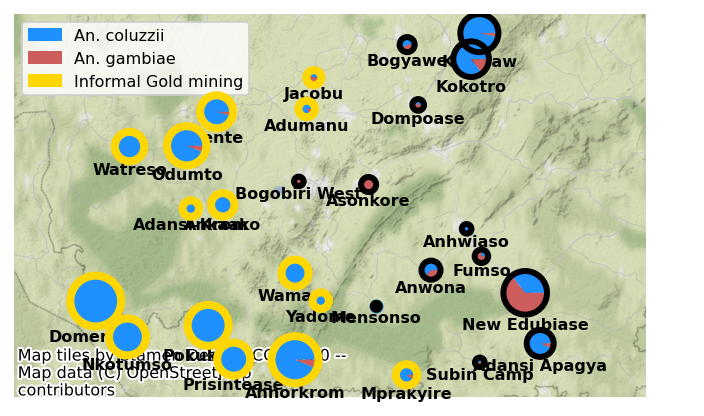

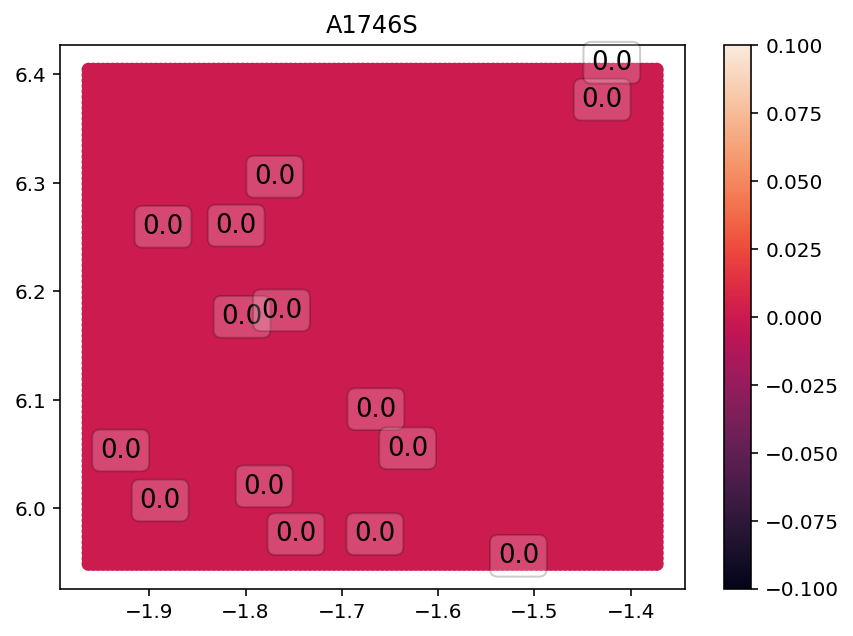

In [9]:
pn.extension()

# get list of aa changes for the dropdown picker
snp_list = list(np.unique(af_long['aa_change']))
# list of model choices
model_list = ['GAM', 'Interpolate']
# example logo 
example_logo = '/home/sanj/projects/IR/rna-seq-busia/anoph_poster.jpg'
# panel description
desc = "A simple GAM and interpolation of allele frequencies at of variants of interest. Text values are frequencies at sample sites."
# Specify the panel widgets, one for aa_change, one for model, one for number of splines in the GAM 
snp_var = pn.widgets.Select(options=snp_list, name='Variant Of Interest', width=250)
model_var = pn.widgets.Select(options=model_list, name='Model', width=250)
nsplines_var = pn.widgets.IntSlider(start=1, end=25, step=1, value=10, name='GAM splines', width=250)

# Specify logo and panes, one for model pic, and one for sample map
logo = pn.panel(example_logo, height=150, align="center")
model_panel = pn.pane.Matplotlib(tight=True, sizing_mode='stretch_width')
map_panel = pn.pane.Matplotlib(plotSampleMap(meta), tight=True, align='center', sizing_mode='stretch_width')

# The next few lines update the variables when a widget value is changed 
@pn.depends(snp_var.param.value, model_var.param.value,nsplines_var.param.value, watch=True)
def update_mpl_pane(snp_var, model_var, nsplines_var):
    model_panel.object = modelAF(snp_var=snp_var, model_var=model_var, nsplines_var=nsplines_var) # edit the model_panel object by running modelAF() with new values

update_mpl_pane(snp_var.value, model_var.value, nsplines_var.value)

# Specify organisation of panes, and .servable() to turn it into server 
pn.Row(pn.Column('# Allele frequency mapping', logo, desc, snp_var, model_var, nsplines_var), pn.Column(pn.Row(model_panel, map_panel))).servable()
